In [2]:
import numpy as np
import scipy as sp
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import mne
from mne.decoding import ReceptiveField, TimeDelayingRidge
import os
import re
import pickle
from utils import Subject, SplitDataset, TRF, split_data
from IPython.display import clear_output

# READING THE ECoG DATA

In [15]:
# ECoG dataset
DS_DIR = './ds005574-1.0.2/'
ECOGPREP_DIR = os.path.join(DS_DIR, 'derivatives/ecogprep/')
ECOGGQC_DIR = os.path.join(DS_DIR, 'derivatives/ecogqc/')
SUB_NAMES = [f'sub-0{i}' for i in range(10)]

In [16]:
s1 = Subject(1)
mne.io.read_raw_fif(s1.hg_path)

Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.


<Raw | sub-01_task-podcast_desc-highgamma_ieeg.fif, 99 x 921600 (1800.0 s), ~118 KiB, data not loaded>

# REMOVING BAD ELECTRODES

# READING THE SYLBER FEATURES

In [17]:
# sylber features of the podcast
SYLBER_FEAT_DIR = './pickled_podcast/'
def open_pickle(pth):
    with open(pth, 'rb') as handle:
        b = pickle.load(handle)
    return b

full_sylber_features = open_pickle(os.path.join(SYLBER_FEAT_DIR,
'merged_output.pickle'))

In [ ]:
print(full_sylber_features.keys())
# Hubert (sylber) returns features at 50Hz
print(full_sylber_features['hidden_states'].shape[0]/(50*60))
print(full_sylber_features['segments'][-1]/(16000*60))

dict_keys(['segments', 'segment_features', 'hidden_states'])
29.998
[25.36695533 25.3669556 ]


[Temporal respons functions](https://mne.tools/stable/generated/mne.decoding.ReceptiveField.html), such as the one used in [this paper](https://ai.meta.com/research/publications/emergence-of-language-in-the-developing-brain/) require that the input and output have the same size.

However, our ECoG data is sampled at $512Hz$, and Sylber's features are sampled at $50Hz$, which leaves us with two solutions:

- Downsample our ECoG signal, leaving us with a lot of information loss
- Upsample our features signal

In [19]:
HIDDEN_STATES = full_sylber_features['hidden_states']
SYLBER_PCA = 50
if SYLBER_PCA:
    pca = PCA(n_components=SYLBER_PCA)
    HIDDEN_STATES = pca.fit_transform(HIDDEN_STATES)

# FINDING APPROPRIATE RIDGE REGULARIZATION

We try and find an appropriate $\alpha$ value for the ridge regularization, searching over 10 logarithmically spaced values between $10^{-2}$ and $10^7$, similarly to J.R.K's paper.

In [20]:
def run_pipeline(sub_num, hidden_states, train_ratio=0.5, tmin=-0.2, tmax=1.0, sfreq=256, alpha=1.0, test_ratio=0.5):
    '''
    test_ratio: float: ratio of the test set to compute the score on
    '''
    dataset = split_data(sub_num, train_ratio, hidden_states, target_freq=sfreq)
    trf_model = TRF(tmin, tmax, sfreq, alpha)
    trf_model.fit(dataset)
    # score if asked
    score = None
    if test_ratio is not None:
        test_split_idx = int(test_ratio * dataset.test_X.shape[0])
        score = trf_model.model.score(dataset.test_X[:test_split_idx], dataset.test_y[:test_split_idx])
        score = np.mean(score)
        print(f"α: {alpha} Test score: {score:.4f}")

    filename = f'sub-0{sub_num}_r{train_ratio}_min{tmin}_max{tmax}_f{sfreq}_a{alpha}.pickle'
    trf_model.save(filename)
    print("Fitted model alpha:", trf_model.model.estimator.alpha)

    return trf_model, dataset, score

In [32]:
# a preliminary search was conducted over one patient, and found that
# an alpha value in this range was best
alphas = np.logspace(np.log10(0.1), np.log10(1e8), num=10)
n_alphas = len(alphas)
sub_nums = range(1, 10)  # sub_num 1 to 9
scores_matrix = np.zeros((len(sub_nums), n_alphas))

# Run all combinations
for subj_idx, sub_num in enumerate(sub_nums):
    for alpha_idx, alpha in enumerate(alphas):
        print(f"Sub {sub_num} | Testing alpha={alpha:.2e}")
        # HEAVILY REDUCED SETUP
        model, dataset, score = run_pipeline(
            sub_num=sub_num,
            hidden_states=HIDDEN_STATES,
            train_ratio=0.2,
            test_ratio=1/8,
            tmin = -0.2,
            tmax = 0.2,
            sfreq=50,  # downsampled for efficiency
            alpha=alpha
        )
        scores_matrix[subj_idx, alpha_idx] = score
        del model, dataset

# Save scores for later use
np.save("scores_matrix.npy", scores_matrix)
np.save("alphas.npy", alphas)

Sub 1 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1020.15it/s]


α: 0.1 Test score: 0.0755
Fitted model alpha: 0.1
Sub 1 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1017.90it/s]


α: 1.0 Test score: 0.0755
Fitted model alpha: 1.0
Sub 1 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1019.47it/s]


α: 10.0 Test score: 0.0756
Fitted model alpha: 10.0
Sub 1 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1022.32it/s]


α: 100.0 Test score: 0.0759
Fitted model alpha: 100.0
Sub 1 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1023.03it/s]


α: 1000.0 Test score: 0.0783
Fitted model alpha: 1000.0
Sub 1 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1016.97it/s]


α: 10000.0 Test score: 0.0852
Fitted model alpha: 10000.0
Sub 1 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1027.39it/s]


α: 100000.0 Test score: 0.0923
Fitted model alpha: 100000.0
Sub 1 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1029.06it/s]


α: 1000000.0 Test score: 0.0850
Fitted model alpha: 1000000.0
Sub 1 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1053.24it/s]


α: 10000000.0 Test score: 0.0698
Fitted model alpha: 10000000.0
Sub 1 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-01/ieeg/sub-01_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 99 channels


100%|██████████| Sample : 5049/5049 [00:04<00:00, 1054.48it/s]


α: 100000000.0 Test score: 0.0635
Fitted model alpha: 100000000.0
Sub 2 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00, 1007.68it/s]


α: 0.1 Test score: 0.0162
Fitted model alpha: 0.1
Sub 2 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00, 1011.38it/s]


α: 1.0 Test score: 0.0162
Fitted model alpha: 1.0
Sub 2 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00,  998.92it/s]


α: 10.0 Test score: 0.0162
Fitted model alpha: 10.0
Sub 2 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00, 1002.70it/s]


α: 100.0 Test score: 0.0162
Fitted model alpha: 100.0
Sub 2 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00,  998.18it/s]


α: 1000.0 Test score: 0.0162
Fitted model alpha: 1000.0
Sub 2 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00, 1001.96it/s]


α: 10000.0 Test score: 0.0162
Fitted model alpha: 10000.0
Sub 2 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00,  995.39it/s]


α: 100000.0 Test score: 0.0162
Fitted model alpha: 100000.0
Sub 2 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00, 1007.40it/s]


α: 1000000.0 Test score: 0.0162
Fitted model alpha: 1000000.0
Sub 2 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00,  998.04it/s]


α: 10000000.0 Test score: 0.0162
Fitted model alpha: 10000000.0
Sub 2 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-02/ieeg/sub-02_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 90 channels


100%|██████████| Sample : 4185/4185 [00:04<00:00, 1001.74it/s]


α: 100000000.0 Test score: 0.0162
Fitted model alpha: 100000000.0
Sub 3 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.


/pasteur/appa/homes/hguillau/.local/lib/python3.12/site-packages/mne/decoding/receptive_field.py:514: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  return np.array([pearsonr(y_true[:, ii], y[:, ii])[0] for ii in range(y.shape[-1])])


Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1310.01it/s]


α: 0.1 Test score: 0.0385
Fitted model alpha: 0.1
Sub 3 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1320.78it/s]


α: 1.0 Test score: 0.0385
Fitted model alpha: 1.0
Sub 3 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1323.27it/s]


α: 10.0 Test score: 0.0385
Fitted model alpha: 10.0
Sub 3 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1323.89it/s]


α: 100.0 Test score: 0.0385
Fitted model alpha: 100.0
Sub 3 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1323.30it/s]


α: 1000.0 Test score: 0.0385
Fitted model alpha: 1000.0
Sub 3 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1319.90it/s]


α: 10000.0 Test score: 0.0385
Fitted model alpha: 10000.0
Sub 3 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1322.23it/s]


α: 100000.0 Test score: 0.0385
Fitted model alpha: 100000.0
Sub 3 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:21<00:00, 1321.19it/s]


α: 1000000.0 Test score: 0.0385
Fitted model alpha: 1000000.0
Sub 3 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:20<00:00, 1333.29it/s]


α: 10000000.0 Test score: 0.0385
Fitted model alpha: 10000000.0
Sub 3 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 235 channels


100%|██████████| Sample : 27965/27965 [00:19<00:00, 1405.05it/s]


α: 100000000.0 Test score: 0.0385
Fitted model alpha: 100000000.0
Sub 4 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1240.36it/s]


α: 0.1 Test score: 0.0651
Fitted model alpha: 0.1
Sub 4 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1184.66it/s]


α: 1.0 Test score: 0.0651
Fitted model alpha: 1.0
Sub 4 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1202.82it/s]


α: 10.0 Test score: 0.0651
Fitted model alpha: 10.0
Sub 4 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1213.35it/s]


α: 100.0 Test score: 0.0651
Fitted model alpha: 100.0
Sub 4 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1206.86it/s]


α: 1000.0 Test score: 0.0651
Fitted model alpha: 1000.0
Sub 4 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1199.71it/s]


α: 10000.0 Test score: 0.0651
Fitted model alpha: 10000.0
Sub 4 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1179.48it/s]


α: 100000.0 Test score: 0.0651
Fitted model alpha: 100000.0
Sub 4 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1173.36it/s]


α: 1000000.0 Test score: 0.0651
Fitted model alpha: 1000000.0
Sub 4 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1164.56it/s]


α: 10000000.0 Test score: 0.0651
Fitted model alpha: 10000000.0
Sub 4 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-04/ieeg/sub-04_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 143 channels


100%|██████████| Sample : 10439/10439 [00:08<00:00, 1184.95it/s]


α: 100000000.0 Test score: 0.0651
Fitted model alpha: 100000000.0
Sub 5 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1293.14it/s]


α: 0.1 Test score: 0.0082
Fitted model alpha: 0.1
Sub 5 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1288.69it/s]


α: 1.0 Test score: 0.0082
Fitted model alpha: 1.0
Sub 5 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1294.21it/s]


α: 10.0 Test score: 0.0082
Fitted model alpha: 10.0
Sub 5 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1294.01it/s]


α: 100.0 Test score: 0.0082
Fitted model alpha: 100.0
Sub 5 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1331.99it/s]


α: 1000.0 Test score: 0.0082
Fitted model alpha: 1000.0
Sub 5 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1378.14it/s]


α: 10000.0 Test score: 0.0082
Fitted model alpha: 10000.0
Sub 5 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1379.78it/s]


α: 100000.0 Test score: 0.0082
Fitted model alpha: 100000.0
Sub 5 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1382.54it/s]


α: 1000000.0 Test score: 0.0082
Fitted model alpha: 1000000.0
Sub 5 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1381.87it/s]


α: 10000000.0 Test score: 0.0082
Fitted model alpha: 10000000.0
Sub 5 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-05/ieeg/sub-05_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 159 channels


100%|██████████| Sample : 12879/12879 [00:09<00:00, 1362.18it/s]


α: 100000000.0 Test score: 0.0082
Fitted model alpha: 100000000.0
Sub 6 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1404.32it/s]


α: 0.1 Test score: 0.0908
Fitted model alpha: 0.1
Sub 6 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1405.77it/s]


α: 1.0 Test score: 0.0908
Fitted model alpha: 1.0
Sub 6 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:10<00:00, 1383.22it/s]


α: 10.0 Test score: 0.0908
Fitted model alpha: 10.0
Sub 6 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:10<00:00, 1390.61it/s]


α: 100.0 Test score: 0.0908
Fitted model alpha: 100.0
Sub 6 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1418.17it/s]


α: 1000.0 Test score: 0.0908
Fitted model alpha: 1000.0
Sub 6 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1417.67it/s]


α: 10000.0 Test score: 0.0908
Fitted model alpha: 10000.0
Sub 6 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1433.95it/s]


α: 100000.0 Test score: 0.0908
Fitted model alpha: 100000.0
Sub 6 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1433.92it/s]


α: 1000000.0 Test score: 0.0908
Fitted model alpha: 1000000.0
Sub 6 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1480.72it/s]


α: 10000000.0 Test score: 0.0908
Fitted model alpha: 10000000.0
Sub 6 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-06/ieeg/sub-06_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 166 channels


100%|██████████| Sample : 14027/14027 [00:09<00:00, 1407.53it/s]


α: 100000000.0 Test score: 0.0908
Fitted model alpha: 100000000.0
Sub 7 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:06<00:00, 1133.87it/s]


α: 0.1 Test score: 0.1007
Fitted model alpha: 0.1
Sub 7 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1163.52it/s]


α: 1.0 Test score: 0.1007
Fitted model alpha: 1.0
Sub 7 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1159.53it/s]


α: 10.0 Test score: 0.1007
Fitted model alpha: 10.0
Sub 7 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1163.71it/s]


α: 100.0 Test score: 0.1007
Fitted model alpha: 100.0
Sub 7 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1159.10it/s]


α: 1000.0 Test score: 0.1007
Fitted model alpha: 1000.0
Sub 7 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1170.91it/s]


α: 10000.0 Test score: 0.1007
Fitted model alpha: 10000.0
Sub 7 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1177.23it/s]


α: 100000.0 Test score: 0.1007
Fitted model alpha: 100000.0
Sub 7 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1160.22it/s]


α: 1000000.0 Test score: 0.1007
Fitted model alpha: 1000000.0
Sub 7 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1155.46it/s]


α: 10000000.0 Test score: 0.1007
Fitted model alpha: 10000000.0
Sub 7 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-07/ieeg/sub-07_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 116 channels


100%|██████████| Sample : 6902/6902 [00:05<00:00, 1158.40it/s]


α: 100000000.0 Test score: 0.1007
Fitted model alpha: 100000000.0
Sub 8 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  947.77it/s]


α: 0.1 Test score: 0.0291
Fitted model alpha: 0.1
Sub 8 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  950.27it/s]


α: 1.0 Test score: 0.0291
Fitted model alpha: 1.0
Sub 8 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  951.83it/s]


α: 10.0 Test score: 0.0291
Fitted model alpha: 10.0
Sub 8 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  955.60it/s]


α: 100.0 Test score: 0.0291
Fitted model alpha: 100.0
Sub 8 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  949.72it/s]


α: 1000.0 Test score: 0.0291
Fitted model alpha: 1000.0
Sub 8 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  952.16it/s]


α: 10000.0 Test score: 0.0291
Fitted model alpha: 10000.0
Sub 8 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  949.78it/s]


α: 100000.0 Test score: 0.0291
Fitted model alpha: 100000.0
Sub 8 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  944.49it/s]


α: 1000000.0 Test score: 0.0291
Fitted model alpha: 1000000.0
Sub 8 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  952.86it/s]


α: 10000000.0 Test score: 0.0291
Fitted model alpha: 10000000.0
Sub 8 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-08/ieeg/sub-08_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 72 channels


100%|██████████| Sample : 2700/2700 [00:02<00:00,  949.93it/s]


α: 100000000.0 Test score: 0.0291
Fitted model alpha: 100000000.0
Sub 9 | Testing alpha=1.00e-01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:13<00:00, 1287.26it/s]


α: 0.1 Test score: 0.0714
Fitted model alpha: 0.1
Sub 9 | Testing alpha=1.00e+00
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:13<00:00, 1309.77it/s]


α: 1.0 Test score: 0.0714
Fitted model alpha: 1.0
Sub 9 | Testing alpha=1.00e+01
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:13<00:00, 1342.86it/s]


α: 10.0 Test score: 0.0714
Fitted model alpha: 10.0
Sub 9 | Testing alpha=1.00e+02
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:13<00:00, 1346.77it/s]


α: 100.0 Test score: 0.0714
Fitted model alpha: 100.0
Sub 9 | Testing alpha=1.00e+03
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:13<00:00, 1294.24it/s]


α: 1000.0 Test score: 0.0714
Fitted model alpha: 1000.0
Sub 9 | Testing alpha=1.00e+04
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:11<00:00, 1511.64it/s]


α: 10000.0 Test score: 0.0714
Fitted model alpha: 10000.0
Sub 9 | Testing alpha=1.00e+05
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:13<00:00, 1373.59it/s]


α: 100000.0 Test score: 0.0714
Fitted model alpha: 100000.0
Sub 9 | Testing alpha=1.00e+06
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:12<00:00, 1408.03it/s]


α: 1000000.0 Test score: 0.0714
Fitted model alpha: 1000000.0
Sub 9 | Testing alpha=1.00e+07
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:13<00:00, 1309.32it/s]


α: 10000000.0 Test score: 0.0714
Fitted model alpha: 10000000.0
Sub 9 | Testing alpha=1.00e+08
Opening raw data file ./ds005574-1.0.2/derivatives/ecogprep/sub-09/ieeg/sub-09_task-podcast_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.
Fitting 1 epochs, 188 channels


100%|██████████| Sample : 17954/17954 [00:12<00:00, 1424.59it/s]


α: 100000000.0 Test score: 0.0714
Fitted model alpha: 100000000.0


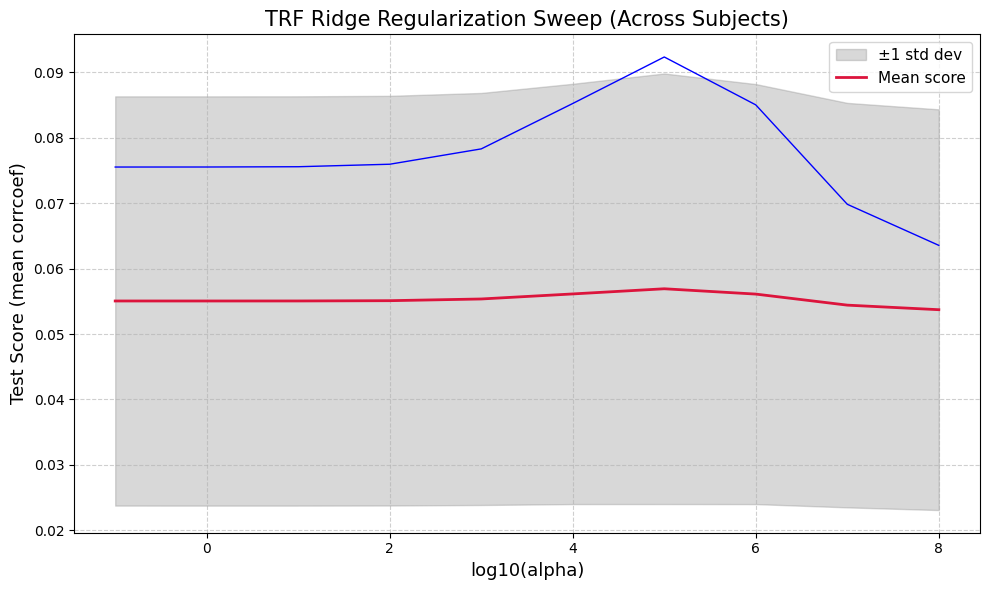

In [5]:
scores_matrix = np.load('scores_matrix.npy')
mean_scores = np.mean(scores_matrix, axis=0)
std_scores = np.std(scores_matrix, axis=0)

alphas = np.logspace(np.log10(0.1), np.log10(1e8), num=10)
plt.figure(figsize=(10, 6))
log_alphas = np.log10(alphas)

# Plot all subject lines
for i, subject_scores in enumerate(scores_matrix):
    if i != 0:
        continue
    plt.plot(log_alphas, subject_scores, color='blue', linewidth=1, alpha=1)

# Plot mean ± std band
plt.fill_between(log_alphas, mean_scores - std_scores, mean_scores + std_scores,
                 color='gray', alpha=0.3, label='±1 std dev')

# Plot mean line
plt.plot(log_alphas, mean_scores, color='crimson', linewidth=2.0, label='Mean score')

plt.xlabel('log10(alpha)', fontsize=13)
plt.ylabel('Test Score (mean corrcoef)', fontsize=13)
plt.title('TRF Ridge Regularization Sweep (Across Subjects)', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()
